In [6]:
import os
os.chdir('../..')


In [2]:
import matplotlib.patches as patches
from data import ecg5k, pronostia
import pickle as pk
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import gc

DATASETS = [('ncmapss', 'N-CMAPSS', 128),
            ('ecg5k', 'ECG5000', 128), 
            ('pronostia', 'PRONOSTIA', 128),
            ('wine', 'WINE', 128),
            ('shares', 'SHARES', 64)]
COLORS = ['red', 'blue', 'orange', 'green']



FileNotFoundError: [Errno 2] No such file or directory: 'diffusion/results/ncmapss/train-meta-attributes_128.pk'

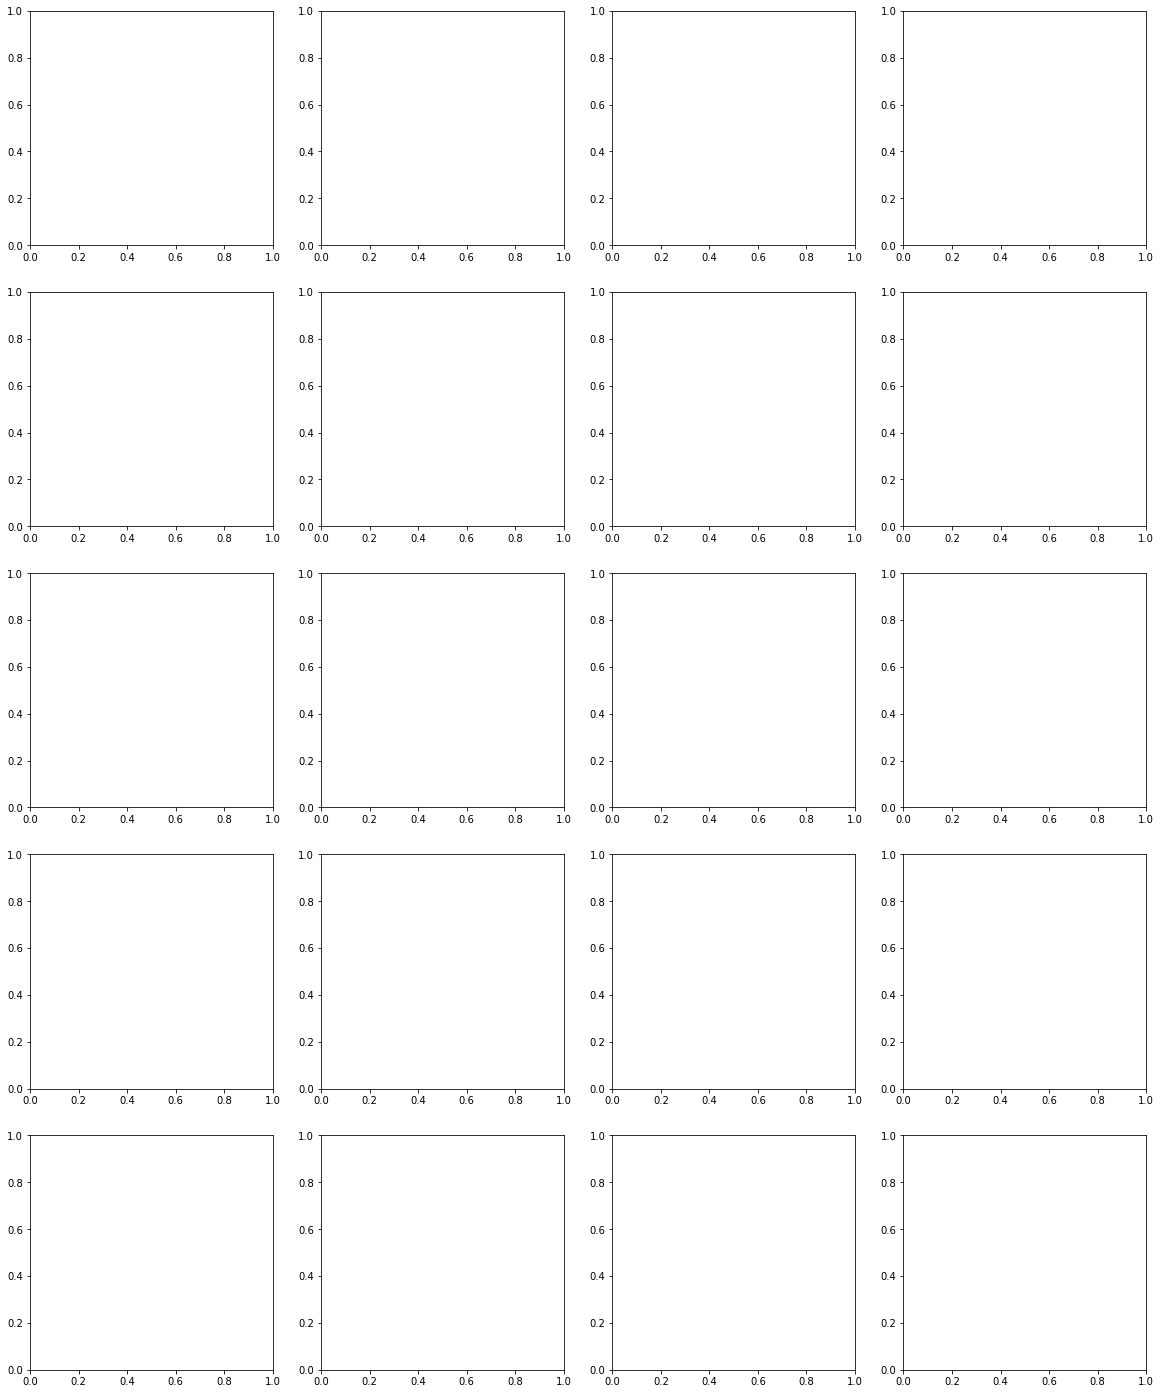

In [34]:
plt.rcParams['figure.figsize'] = [20, 25]
fig, axs = plt.subplots(len(DATASETS), 4)


for i, (dataset, name, tslen) in enumerate(DATASETS):
    attributes = pk.load(open(f'diffusion/results/{dataset}/train-meta-attributes_{tslen}.pk', 'rb'))

    axs[i, 0].set_ylabel(name, fontsize=25)
    for j, color in enumerate(COLORS):
        axs[i,j].tick_params(axis='both', which='major', labelsize=14)
        axs[i,j].plot(attributes[j]['signal'], c=color)

    del attributes
    gc.collect()
    
plt.savefig("dataset_signals.svg")

In [17]:
plt.savefig("dataset_signals.svg")

<Figure size 1440x1800 with 0 Axes>

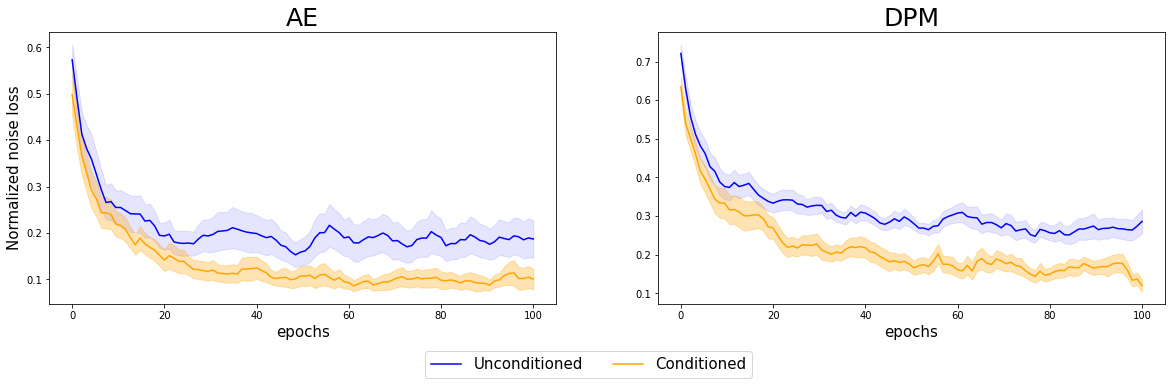

In [106]:
import json
import numpy as np

plt.rcParams['figure.figsize'] = [20, 5]
fig, axs = plt.subplots(1, 2)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def plot_confidence(data, ax, color='b', alpha=0.2, label=None):
    x = np.linspace(0, 100, len(data[0]))
    y = np.array(data).mean(axis=0)
    #some confidence interval
    ci = 1.96 * np.array(data).std(axis=0)/np.sqrt(len(x))

    ax.plot(x,y, color=color, label=label)
    ax.fill_between(x, (y-ci), (y+ci), color=color, alpha=alpha)
    
ae_cond_hist = []
ae_uncond_hist = []
dpm_cond_hist = []
dpm_uncond_hist = []

for i, (dataset, name, tslen) in enumerate(DATASETS):
    h = [f for f  in os.listdir(f'diffusion/results/{dataset}/{tslen}/') if 'diffusion_model' in f and '.json' in f]
    h = sorted(h)
    
    #axs[i, 0].set_ylabel(name, fontsize=25)
    
    for j, (net, files) in enumerate(zip(["AE", "DPM"], [list(filter(lambda x: 'dpm' not in x, h)), 
                                     list(filter(lambda x: 'dpm' in x, h))])):
    
        values = []
        for cond, file in zip([False, True], files):
            history = json.load(open(f'diffusion/results/{dataset}/{tslen}/' + file, 'r'))
            values += list(history['val_noise_loss'][:100])
            
        _min, _max = min(values), max(values)
        for cond, file in zip([False, True], files):
            
            history = json.load(open(f'diffusion/results/{dataset}/{tslen}/' + file, 'r'))
            
            n = (np.array(history['val_noise_loss'][:100]) - _min) / (_max - _min)
            
            n = moving_average(n, 5)
            if net == 'AE':
                if cond:
                    ae_cond_hist.append(n)
                else:
                    ae_uncond_hist.append(n)
                    
            if net == 'DPM':
                if cond:
                    dpm_cond_hist.append(n)
                else:
                    dpm_uncond_hist.append(n)
                    
    
plt.savefig("noise_loss.svg")

axs[0].set_title('AE', fontsize=25)
plot_confidence(ae_uncond_hist, axs[0], alpha=0.1, label="Unconditioned")
plot_confidence(ae_cond_hist, axs[0], color='orange', alpha=0.3, label="Conditioned")

axs[1].set_title('DPM', fontsize=25)
plot_confidence(dpm_uncond_hist, axs[1], alpha=0.1)
plot_confidence(dpm_cond_hist, axs[1], color='orange', alpha=0.3)

axs[0].set_ylabel('Normalized noise loss', fontsize=15)
axs[0].set_xlabel('epochs', fontsize=15)
axs[1].set_xlabel('epochs', fontsize=15)


axs[0].legend(ncol=2, loc=4, fontsize=15, bbox_to_anchor=(0.9, -0.3, 0.5, 0.5))

plt.savefig("denosing_loss.svg")

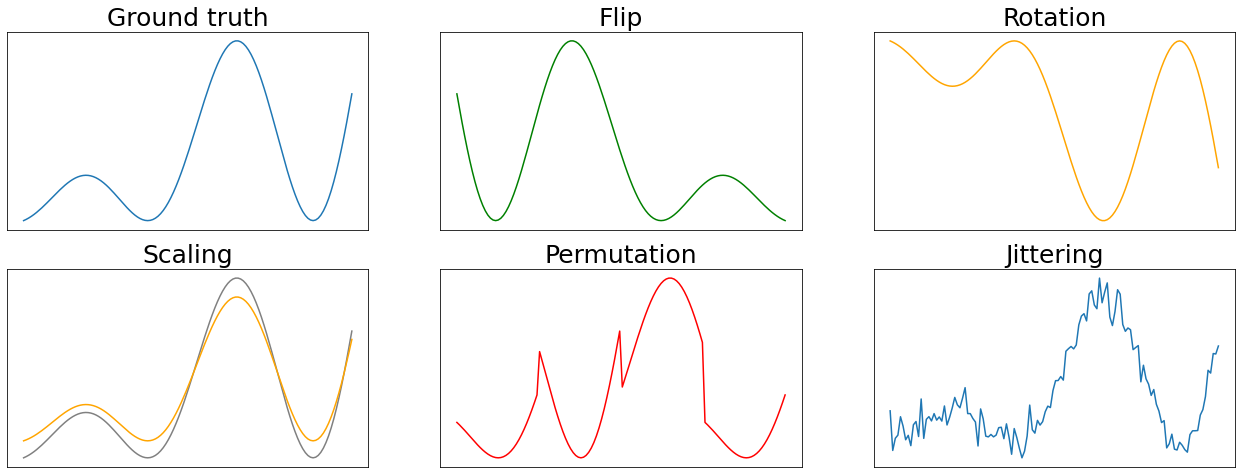

In [111]:
from matplotlib import pyplot as plt
import numpy as np
import random

Fs = 128
f = 2

x = np.arange(128)
y = np.sin(2 * np.pi * f * x / Fs) * (x / 128) + (x / 128) - 0.6

fig, axs = plt.subplots(2, 3, sharex=False, figsize=(22,8))


axs[0, 0].plot(x, y)
axs[0, 0].set_title('Ground truth', fontsize=25)

for row in axs:
    for ax in row:
        ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 


y1 = y[::-1]
axs[0,1].plot(x, y1,  color='green')
axs[0,1].set_title('Flip', fontsize=25)

y2 = 1 - y
axs[0,2].plot(x, y2, color='orange')
axs[0,2].set_title('Rotation', fontsize=25)

y3 = y * 0.8
axs[1,0].plot(x, y, color='gray')
axs[1,0].plot(x, y3, color='orange')
axs[1,0].set_title('Scaling', fontsize=25)


idx = [1, 3, 2, 0]
y4 = y * 1
step = y.shape[0] // len(idx)
for i, k in enumerate(idx):
    y4[i*step:(i+1)*step] = y4[k*step:(k+1)*step]
axs[1,1].plot(x, y4, color='red')
axs[1,1].set_title('Permutation', fontsize=25)


y5 = y + (np.random.normal(0, 1, size=y.shape) * 0.1)
axs[1,2].plot(x, y5)
axs[1,2].set_title('Jittering', fontsize=25)

plt.savefig('basic_da.svg')

In [1]:
import os
os.chdir('../..')
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
# import matplotlib.patches as patches
from data import ecg5k, pronostia
import pickle as pk
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import gc
import tensorflow as tf
from diffusion import net
from diffusion import meta
import numpy as np


(20, 32)
3
2
1
(10, 32)
1
(10, 32)
1
(20, 32)
3
2
1
(10, 32)
1
(20, 32)
1
(10, 32)
1
(20, 32)
1
(20, 32)
1
(10, 32)
1
(20, 32)
1
(10, 32)
1
(10, 32)
1
(20, 32)
1
(10, 32)
1
(20, 32)
1
(10, 32)
1
(20, 32)
1
(10, 32)
1
(20, 32)
1


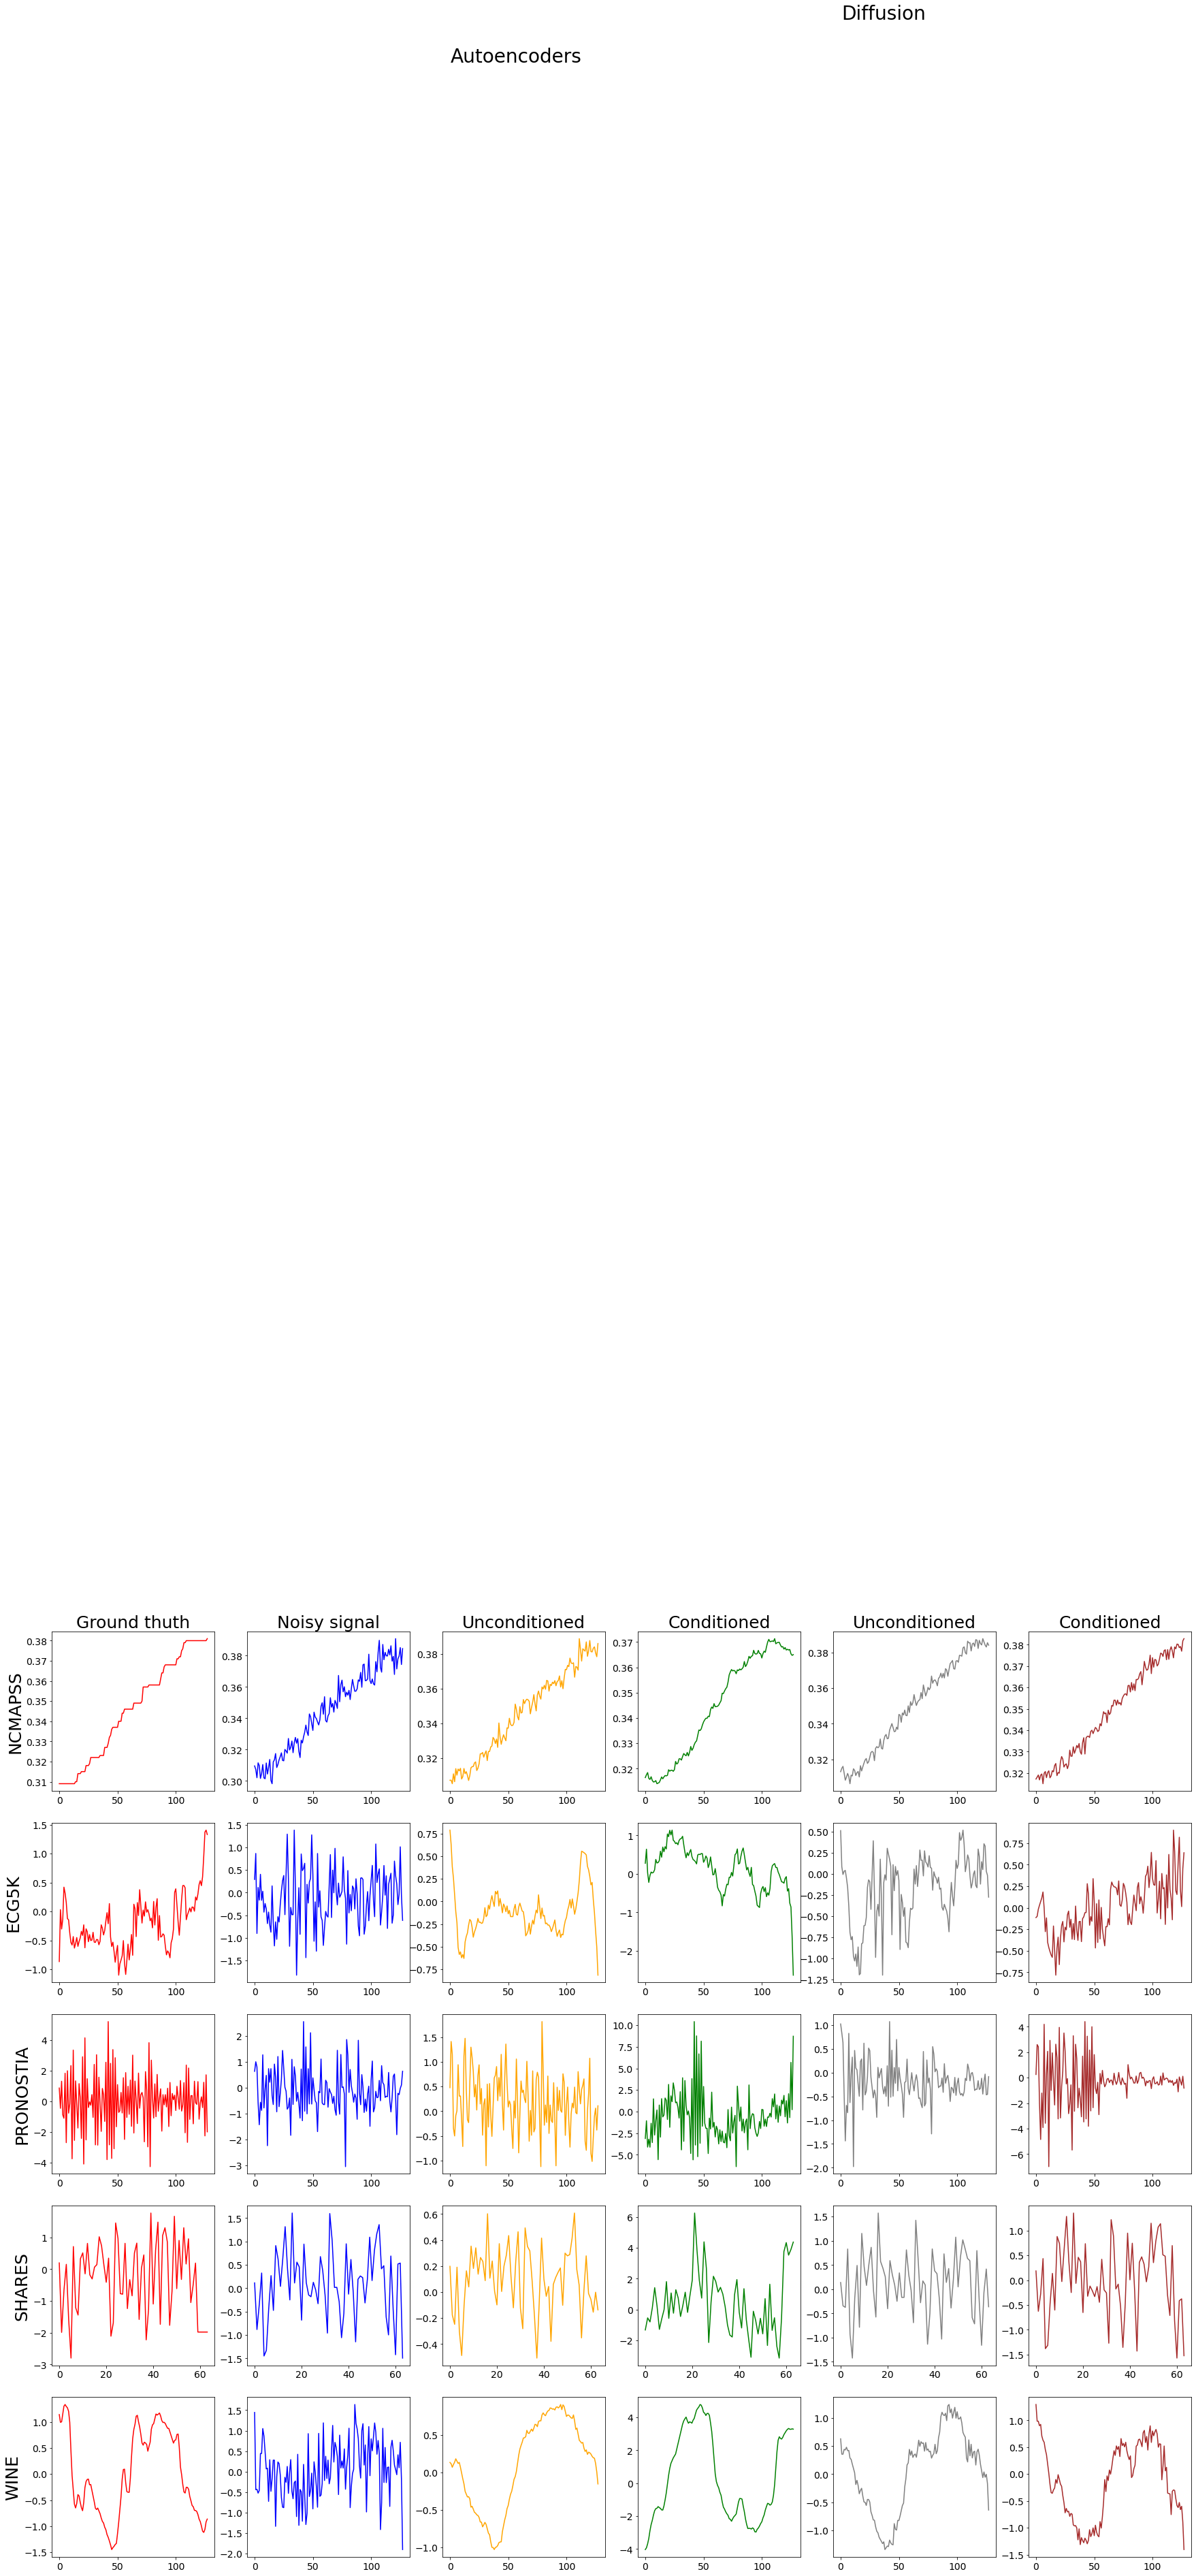

In [10]:



DATASETS = [('ncmapss', 'N-CMAPSS', 128),
            ('ecg5k', 'ECG5000', 128), 
            ('pronostia', 'PRONOSTIA', 128),
            ('shares', 'SHARES', 64),
            ('wine', 'WINE', 128),]
COLORS = ['red', 'blue', 'orange', 'green', 'gray', 'brown']

SAMPLE = {
    "ncmapss": 2,
    "ecg5k": 0,
    "pronostia": 10,
    "wine": 0,
    "shares": 0,
}

NOISE_CONF = {
    "ncmapss": lambda x: 0.005,
    "ecg5k": lambda x: 0.6,
    "pronostia": lambda x: 0.8,
    "wine": lambda x: 0.6,
    "shares": lambda x: 0.6,
}

plt.rcParams['figure.figsize'] = [30, 25]
fig, axs = plt.subplots(len(DATASETS), 6)

COLS = {
    ('ae', False): 2,
    ('ae', True): 3,
    ('dpm', False): 4,
    ('dpm', True): 5,
}

TS = {
    ("ncmapss", "ae", True): 1,
    ("ncmapss", "ae", False): 1,
    ("ncmapss", "dpm", True): 3,
    ("ncmapss", "dpm", False): 3,
    ("ecg5k", "ae", True): 1,
    ("ecg5k", "ae", False): 1,
    ("ecg5k", "dpm", True): 1,
    ("ecg5k", "dpm", False): 1,
    ("pronostia", "ae", True): 1,
    ("pronostia", "ae", False): 1,
    ("pronostia", "dpm", True): 1,
    ("pronostia", "dpm", False): 1,    
    ("wine", "ae", True): 1,
    ("wine", "ae", False): 1,
    ("wine", "dpm", True): 1,
    ("wine", "dpm", False): 1, 
    ("shares", "ae", True): 1,
    ("shares", "ae", False): 1,
    ("shares", "dpm", True): 1,
    ("shares", "dpm", False): 1, 
}


SHOW = {
    ("ncmapss", "ae", True): True,
    ("ncmapss", "ae", False): True,
    ("ncmapss", "dpm", True): True,
    ("ncmapss", "dpm", False): True,
    ("ecg5k", "ae", True): True,
    ("ecg5k", "ae", False): True,
    ("ecg5k", "dpm", True): True,
    ("ecg5k", "dpm", False): True,
    ("pronostia", "ae", True): True,
    ("pronostia", "ae", False): True,
    ("pronostia", "dpm", True): True,
    ("pronostia", "dpm", False): True,
    ("wine", "ae", True): True,
    ("wine", "ae", False): True,
    ("wine", "dpm", True): True,
    ("wine", "dpm", False): True,
    ("shares", "ae", True): True,
    ("shares", "ae", False): True,
    ("shares", "dpm", True): True,
    ("shares", "dpm", False): True,
}

def plot(model_file, noise_signal , noise_rates, dataset, attributes, axs, i):
    model_type = 'dpm' if 'dpm' in model_file else 'ae'
    cond = 'c1' in model_file
    
    if not SHOW[(dataset, model_type, cond)]:
        return
    
    model = tf.keras.models.load_model(model_file, compile=False)
    
    signal_rates = 1 - noise_rates
 
    num_attributes = model.inputs[1].shape[1]

    if 'dpm' in model_file:
        dm = net.SteppedDiffusionModel(
                        tslen, [16, 32, 32, 64], 
                        block_depth=2, 
                        timesteps=20, 
                        max_noise_level=10,
                        mode='diffusion',
                        feature_loss_net=s2a_model, 
                        num_features=num_attributes, 
                        feature_names=meta.ATTRIBUTE_NAMES,
                        cond=cond, 
                        feature_loss=False)  

        j = COLS[("dpm", cond)]
                
    else:
        dm = net.DiffusionModel(
                        tslen, [16, 32, 32, 64], 
                        block_depth=2, 
                        noise_rates=[], 
                        mode='diffusion',
                        feature_loss_net=s2a_model, 
                        num_features=num_attributes, 
                        feature_names=meta.ATTRIBUTE_NAMES,
                        cond=cond, 
                        feature_loss=None, 
                        timesteps=10)
        
        j = COLS[("ae", cond)]
     

    dm.network.set_weights(model.get_weights())
    
    noisy_samples = noise_signal

    ts = TS[(dataset, model_type, cond)]
    for t in range(ts, 0, -1):
        print(t)
        t = np.expand_dims(np.array([t]), axis=0).astype('int32')
        noisy_samples, _, _ = dm.neighbourhood(1, noisy_samples=noisy_samples, 
                                                             signal_rates=signal_rates, 
                                                             noise_rates=noise_rates,
                                                             timesteps=t,
                                                             features=attributes)


    axs[i,j].tick_params(axis='both', which='major', labelsize=14)
    axs[i,j].plot(noisy_samples[0,:,0], c=COLORS[j])


xlabels = ["Ground thuth", "Noisy signal", "Unconditioned", "Conditioned", "Unconditioned", "Conditioned"]

for i, (dataset, name, tslen) in enumerate(DATASETS):
    
    
    axs[i, 0].set_ylabel(dataset.upper(), fontsize=25)
    
    if i == 0:
        axs[0,2].text(0.7, 1.3, "Autoencoders", fontsize=28)
        axs[0,4].text(0.75, 1.3, "Diffusion", fontsize=28)       
        for j, label in enumerate(xlabels):
            axs[i, j].set_title(label, fontsize=25)
    
    
    
    dif_model_files = [f'diffusion/results/{dataset}/{tslen}/' + f for f in os.listdir(f"diffusion/results/{dataset}/{tslen}") 
                       if '.h5' in f and 'diffusion' in f]
    
    s2a_model = tf.keras.models.load_model(f'diffusion/results/{dataset}/{tslen}/s2a.h5')
    attributes = pk.load(open(f'diffusion/results/{dataset}/test-meta-attributes_{tslen}.pk', 'rb'))

    signal = attributes[SAMPLE[dataset]]['signal']
    del attributes
    gc.collect()

    
    # raw signal
    axs[i,0].tick_params(axis='both', which='major', labelsize=14)
    axs[i,0].plot(signal, c=COLORS[0])
    
    # noisy signal
    signal = np.expand_dims(signal, axis=[0])
    noise_rates = NOISE_CONF[dataset](signal)
    
    noise = np.random.normal(size=signal.shape)
    noise_signal = signal * (1-noise_rates) + noise * noise_rates
    noise_signal = np.expand_dims(noise_signal, axis=-1).astype('float32')
    
    axs[i,1].tick_params(axis='both', which='major', labelsize=14)
    axs[i,1].plot(noise_signal[0], c=COLORS[1])
    
    # signal meta-attributes
    attributes = s2a_model.predict(np.copy(signal))

    # plot denoisings 
    ts = 1    
    for model_file in dif_model_files:
        plot(model_file, noise_signal, noise_rates, dataset, attributes, axs, i)
    
    
plt.savefig('denoise_samples.svg')

In [84]:
axs

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [112]:
import pandas as pd

X = pd.read_csv('diffusion/notebooks/results.csv')
X['val_loss'] = (X.val_loss - X['min']) / (X['max'] - X['min'])
X = X[~X.val_loss.isnull()]
X = X[X.val_loss != 1]
X = X[(X.aug=='diff_aug')]
X.val_loss.min(), X.val_loss.max()

(0.0, 0.9988398753325421)

In [113]:
X.columns


Index(['ds', 'net', 'aug', 'cond_diff', 'denoise_mode', 'min', 'max',
       'val_loss', 'noise', 'ts'],
      dtype='object')

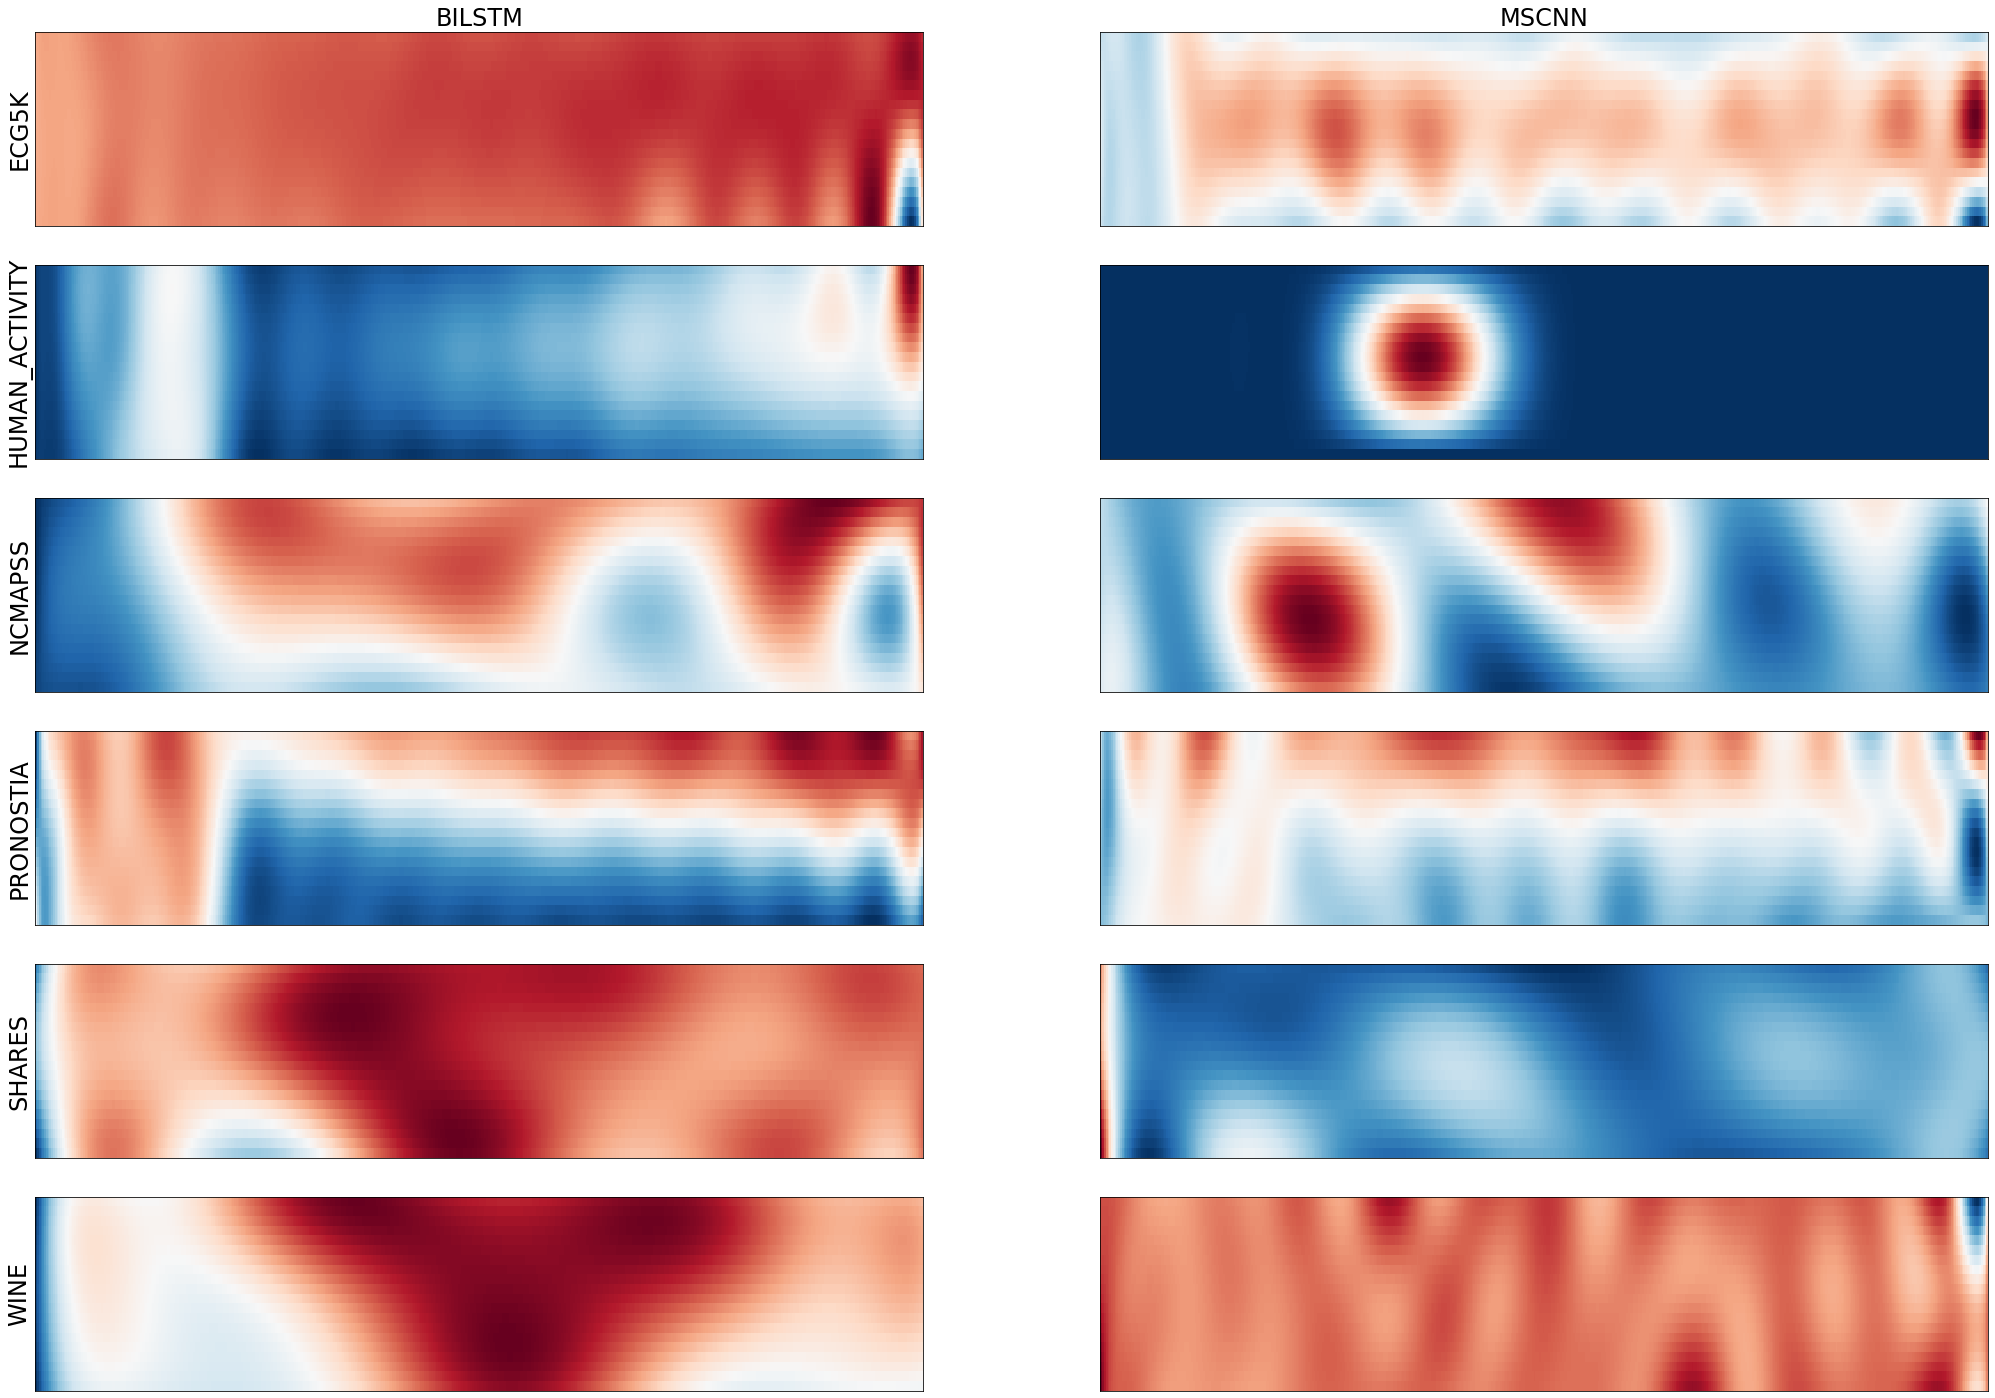

In [116]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [35, 25]
fig, axs = plt.subplots(len(X.ds.drop_duplicates()), len(X.net.drop_duplicates()))

for i, ds in enumerate(X.ds.drop_duplicates()):
    for j, net in enumerate(X.net.drop_duplicates()):
        ax = axs[i, j]
        ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

        if i == 0:
            ax.set_title(f"{net.upper()}", fontsize=24)
        
        if j == 0:
            ax.set_ylabel(f"{ds.upper()}", fontsize=24)
        
        Y = X[(X.ds==ds) & (X.net==net)]

        gp = GaussianProcessRegressor()
        gp.fit(Y[['noise', 'ts']].values, Y.val_loss.values)

        offset = (Y.noise.max() - Y.noise.min()) / 500
        xvalues = np.arange(Y.noise.min(), Y.noise.max(), offset)
        yvalues = np.arange(Y.ts.min(), Y.ts.max(), 0.1)

        a,b = np.meshgrid(xvalues,yvalues)

        x = np.moveaxis(np.vstack([a.ravel(), b.ravel()]), 0, 1)
        predicted = gp.predict(x).reshape(a.shape)

        
        ax.pcolormesh(a, b, 1-predicted, cmap='RdBu')
        
plt.savefig('steps_noise_rates.png')

In [97]:
X

,ds,net,aug,cond_diff,denoise_mode,min,max,val_loss,noise,ts
0,ecg5k,bilstm,diff_aug,False,dpm,0.489958,2.313020,0.000000,0.00,2
1,ecg5k,bilstm,diff_aug,False,dpm,0.489958,2.313020,0.028915,0.00,3
2,ecg5k,bilstm,diff_aug,False,dpm,0.489958,2.313020,0.097632,0.00,1
3,ecg5k,bilstm,diff_aug,False,dpm,0.489958,2.313020,0.098831,0.21,2
4,ecg5k,bilstm,diff_aug,False,dpm,0.489958,2.313020,0.104481,0.11,1
...,...,...,...,...,...,...,...,...,...,...
3225,wine,mscnn,noise_aug,True,ignored,0.547227,1.017551,0.328089,5.79,0
3226,wine,mscnn,noise_aug,True,ignored,0.547227,1.017551,0.331781,2.42,0
3227,wine,mscnn,noise_aug,True,ignored,0.547227,1.017551,0.439022,0.11,0
3228,wine,mscnn,noise_aug,True,ignored,0.547227,1.017551,0.441315,1.26,0


In [53]:
for ds, net in X[['ds', 'net']].drop_duplicates().values:
    print(ds, net)

ecg5k bilstm
ecg5k mscnn
human_activity bilstm
human_activity mscnn
ncmapss bilstm
ncmapss mscnn
pronostia bilstm
pronostia mscnn
shares bilstm
shares mscnn
wine bilstm
wine mscnn


In [34]:
a = np.moveaxis(np.array([[1,2], [3,4]]), 0, 1)

In [35]:
a

array([[1, 3],
       [2, 4]])

In [44]:
X['val_loss'].max()

1.0

In [46]:
predicted.min(), predicted.max()

(-1.1311016082763672, 1.0307502746582031)